# Mastering Image Classification: Building a Deep Learning Model for Natural Scene Recognition

In [1]:
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import kagglehub
from pathlib import Path
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

/opt/anaconda3/envs/dz6/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/dz6/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /opt/anaconda3/envs/dz6/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/opt/anaconda3/envs/dz6/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/dz6/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/dz6/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/dz6/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed

In [2]:
dataset_path = kagglehub.dataset_download("puneet6060/intel-image-classification")

print("Path to dataset files:", dataset_path)

Path to dataset files: /Users/julia/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2


In [3]:
path = Path(dataset_path)
train_path = path / 'seg_train' / 'seg_train'
test_path = path / 'seg_test' / 'seg_test'
pred_path = path / 'seg_pred'

print(len(train_path.ls()))

6


In [4]:
train_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),                 
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_test_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


In [5]:
# Apply transformations while loading datasets
train_data = datasets.ImageFolder(root=train_path, transform=train_transform)
test_data = datasets.ImageFolder(root=test_path, transform=val_test_transform)
pred_data = datasets.ImageFolder(root=pred_path, transform=val_test_transform)

# Split train_data into training and validation sets
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
pred_loader = DataLoader(pred_data, batch_size=batch_size, shuffle=False)


In [6]:

# Helper function to denormalize images for visualization
def denormalize(image):
    # If normalized with mean=[0.5, 0.5, 0.5] and std=[0.5, 0.5, 0.5], reverse it
    image = image * 0.5 + 0.5  # Undo normalization ([-1, 1] -> [0, 1])
    return image

# Visualize a few images from the train_loader
def visualize_augmentations(loader):
    # Get one batch of images and labels
    data_iter = iter(loader)
    images, labels = next(data_iter)

    # Create a grid of images
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    for i in range(5):  # Display 5 images
        ax = axes[i]
        image = images[i]  # Select the i-th image
        label = labels[i]  # Select the i-th label

        # Denormalize the image
        image = denormalize(image)

        # Convert image tensor to numpy array and transpose for plotting
        np_image = image.numpy().transpose((1, 2, 0))  # (C, H, W) -> (H, W, C)

        # Plot the image with its label
        ax.imshow(np_image)
        ax.axis("off")
        ax.set_title(f"Label: {label}")
    plt.show()


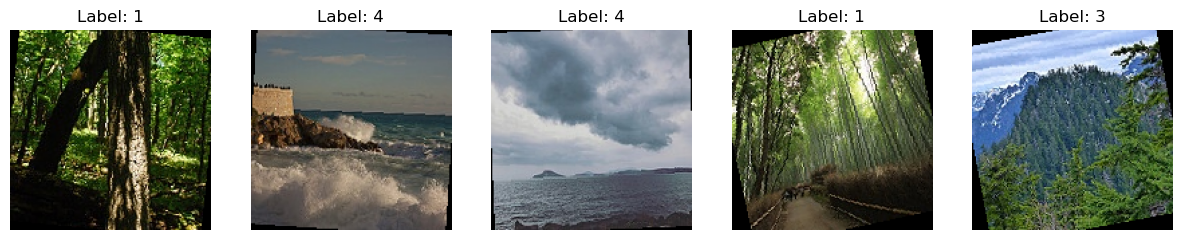

In [7]:
visualize_augmentations(train_loader)

## Building a Simple Convolutional Neural Network (CNN)

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=6):
        super(SimpleCNN, self).__init__()
        
        # Convolutional layer 1: input channels = 3 (RGB), output channels = 32
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Pooling layer (shared for all)
        
        # Convolutional layer 2
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        # Convolutional layer 3
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        
        # Fully connected layer 1
        self.fc1 = nn.Linear(128 * 18 * 18, 256)  # Input size depends on the output from conv layers
        self.fc2 = nn.Linear(256, num_classes)    # Output size matches the number of classes

    def forward(self, x):
        # Convolutional Layer 1 + Activation + Pooling
        x = self.pool(F.relu(self.conv1(x)))
        
        # Convolutional Layer 2 + Activation + Pooling
        x = self.pool(F.relu(self.conv2(x)))
        
        # Convolutional Layer 3 + Activation + Pooling
        x = self.pool(F.relu(self.conv3(x)))
        
        # Flatten
        x = torch.flatten(x, 1)  # Flatten the tensor for the fully connected layers
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x


In [9]:
num_classes = len(train_path.ls())
print(f"Number of classes: {num_classes}")

Number of classes: 6
